In [1]:
import sys
import os
import re
import operator
import csv
import pandas as pd
import matplotlib.pyplot as plt
import random
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV



In [ ]:
word_size = 5
chunk_size = 500

In [2]:
start = re.compile(r'^Address Before a Joint Session.*')
finish = re.compile(r'^NOTE:.*')
line_pat = re.compile('.*')
#Counting a 'true' word as anything 5 letters or longer
word_pat = re.compile(r'\b[a-zA-Z]{'+str(word_size)+',}')

def get_speeches():
    """ 
    Get a list of speeches in each directory
    """
    speeches = []
    for speech in os.listdir('.'):
        if speech[-4:] != '.txt':
            continue
        speeches.append(speech)

    return speeches

def all_words_to_string(speech):
    """
    For each speech we create a dictionary of all words and their counts.
    Then we just export the indexes/words to a single list.
    """
    
    dic = {}
    flag = False
    with open(speech, "r") as f:
        for line in f:
            if not flag:
                if start.match(line):
                    flag = True
                continue
            if finish.match(line):
                break
            result = line_pat.findall(line)
            result2 = word_pat.findall(line)
            for line in result:
                if result2:
                    for word in result2:
                        key1 = word.lower()
                        if key1 not in dic:
                            dic[key1] = 1
                        else:
                            dic[key1] += 1
    
    word_list = list(dic.keys())
    return word_list

In [3]:
#Divide test into 10 chunks of 100 words 
#then create tuple for each, and create tuple list 

categories = ['bush',
              'clinton',
              'obama',
              'trump']

data_dir = './data'
os.chdir(data_dir)
tup_list = []
for i in categories:
    os.chdir(i)
    speeches = get_speeches()
    for speech in speeches:
        word_list = all_words_to_string(speech)
        chunks = len(word_list)//chunk_size
        l_start = 0
        l_end = chunk_size
        for j in range(chunks):
            words = word_list[l_start:l_end]
            l_start += chunk_size
            l_end += chunk_size
            new_word_list = ' '.join(words)
            tup = (new_word_list, i)
            tup_list.append(tup)  
    os.chdir('..')
       
df = pd.DataFrame(tup_list, columns=['text','orator'])

KNeighborsClassifier() ACCURACY:  1.0
bush ACCURACY:  1.0
clinton ACCURACY:  1.0
obama ACCURACY:  1.0
trump ACCURACY:  1.0
Highest accuracy:  1.0
K value : 1


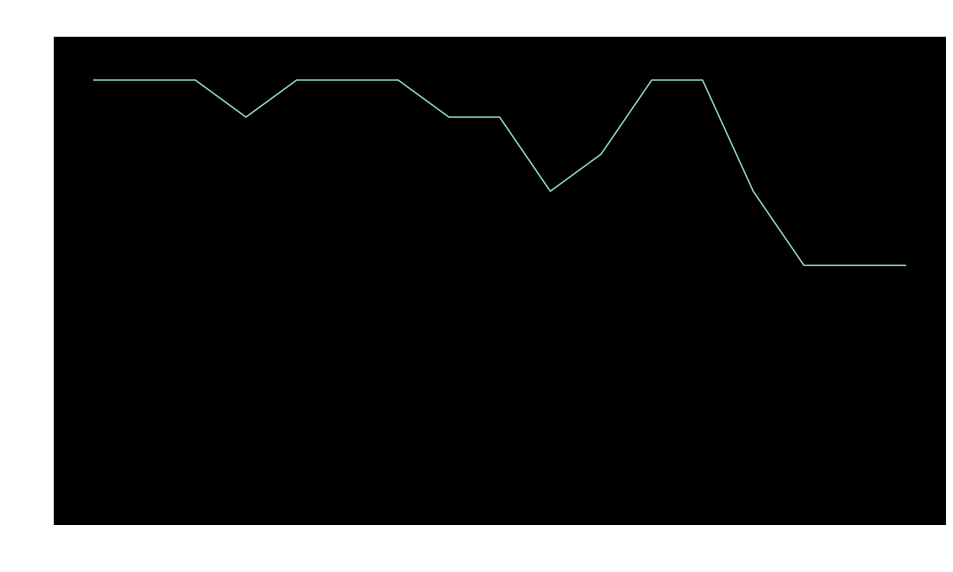

In [4]:
# Loading new data
class Speech:
    def __init__(self, text, orator):
        self.text = text
        self.orator = orator

#Set each speech entry as custom class
speeches = []
for index, row in df.iterrows():
    speech = {'text':row['text'], 'orator':row['orator']} 
    speeches.append(Speech(speech['text'], speech['orator']))
    
seed = 99
train, test = train_test_split(speeches, test_size=.25, random_state=seed)

train_x = [x.text for x in train]
train_y = [x.orator for x in train]

test_x = [x.text for x in test]
test_y = [x.orator for x in test]

# Define Bags of Words Count Vectorizer
vectorizer = CountVectorizer()
#vectorizer = TfidfVectorizer()

# Fit vectorizer to training data, and transformed to provide vectors
train_x_vectors = vectorizer.fit_transform(train_x)

test_x_vectors = vectorizer.transform(test_x)

# Final Variables
# train_x_vectors
# train_y

cat_count = 0

clf_knn = KNeighborsClassifier(n_neighbors=5)
clf_knn.fit(train_x_vectors, train_y)






# Accuracy readouts
print(clf_knn,'ACCURACY: ', clf_knn.score(test_x_vectors, test_y))
f1scores = (f1_score(test_y, 
               clf_knn.predict(test_x_vectors),
               average=None, 
               labels=categories,
               zero_division='warn'))
for i in f1scores:
    print(categories[cat_count]+' ACCURACY: ', i)
    cat_count += 1
    
    k_range = range(1,18)
accuracy_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_x_vectors, train_y)
    accuracy_score = knn.score(test_x_vectors, test_y)
    accuracy_scores.append(accuracy_score)
    
high_acc = (max(accuracy_scores))
high_acc_id = accuracy_scores.index(high_acc)
print('Highest accuracy: ',high_acc)
print('K value :', high_acc_id+1)

plt.figure(figsize=(16,9))
plt.style.use('dark_background')
plt.plot([i for i in k_range], accuracy_scores)
plt.xlabel('Value of K', fontsize=20)
plt.ylabel('Testing Accuracy', fontsize=20)
plt.ylim(0,1.1)
plt.title(str(chunk_size)+' word chunks / '+str(word_size)+'+ letter words', fontsize=30)
plt.savefig('../figs/k_val_plot_'+str(word_size)+'_'+str(chunk_size)+'.png')